In [ ]:
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import scipy
T = 1000

## Problem 1 - Monte Carlo

In this problem, you will compare two Monte Carlo methods for estimating the probability that a standard normal distribution has a value greater than two (i.e., $P(Y > 2 | Y \sim N(0,1))$). For all parts of Problem 1, we will use $T=1000$.

### 1. (a) Naive Monte Carlo

The first method we will use is naive Monte Carlo. Monte Carlo estimates the expected value of a function of a random variable. The probability a random variable is greater than two can be written as an expectation of a function of a random variable --- it is the expected number of times that the random variable is greater than two if we drew a lot of samples from the distribution. So, $P(Y > 2) = E[I(Y>2)]$, where $I(\cdot)$ is an indicator function, which returns 1 when its argument is true and 0 otherwise.\footnote{In your favorite programming language, it is easy to calculate the probability that a standard normal distribution is greater than two --- e.g., simply run {\tt 1-normcdf(2,0,1) = 0.0228} in Matlab. However, I want you to implement these estimators to get a feel for how they behave.} 

Write code that samples $T$ standard normally distributed variables $x_{MC}^{(1)},\ldots, x_{MC}^{(T)} \sim N(0,1)$. Create a vector which cumulatively estimates the Monte Carlo estimate of the probability of seeing a value greater than two after observing each subsequent data point. 

In other words, create a vector ${\bf f}_{MC}$ such that the value of element $t$ in ${\bf f}_{MC}$ is the Markov Carlo estimate of the probability that a standard normal randomly generated value is greater than 2 from $t$ samples (the number of samples in $x_{MC}^{(1)},\ldots, x_{MC}^{(t)}$ that are greater than 2). 

Plot ${\bf f}_{MC}$ vector. Is there anything strange about it? (Does it look like the example we did in class of the Monte Carlo estimate of the average number of dots seen when you roll a die?) Write 1-2 sentences explaining why the plot of the updated Monte Carlo estimate looks the way it does. Also report the final estimate according to the Monte Carlo estimate ($f_{MC}(T)$).

'f_MC(T) = 0.019'

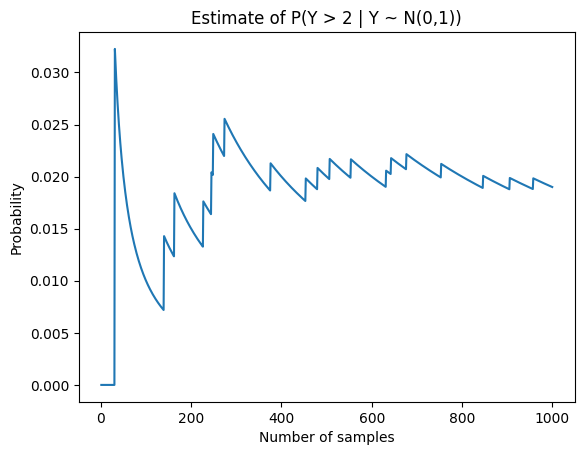

In [ ]:
# Create a consistent random number generator using NumPy's `default_rng`
generator = np.random.default_rng(seed=42)
samples = generator.normal(loc=0.0, scale=1.0, size=(T))
samples_greater_than_2 = (samples > 2) * 1
samples_greater_than_2_cumsum = np.cumsum(samples_greater_than_2)
num_samples_t = np.arange(start=1, stop=len(samples_greater_than_2_cumsum)+1, step=1)
f_MC = samples_greater_than_2_cumsum / num_samples_t
sb.lineplot(x=num_samples_t, y=f_MC)
plt.title('Estimate of P(Y > 2 | Y ~ N(0,1))')
plt.xlabel('Number of samples')
plt.ylabel('Probability')

display(f'f_MC(T) = {f_MC[-1]}')

The $f_{MC}$ vector is strange in that it has a sawtooth-like shape. This constrasts the more undulating pattern seen in the in-class example of estimating the number of dots seen when you roll a die. This could be explained by the fact that, in this exercise, each positive sample will result in a jump in the current estimate, whereas every negative example will not affect the numerator of the estimator, and will instead just increase the denominator by 1. Thus, in periods where there are only negative samples, we see a tapering downward slope.

Per the output above, the final estimate according to the Monte Carlo estimate is $f_{MC}(T) = 0.019$

# Extra out of curiosity

We can compare the estimate we obtain here with the "true" probability.

In [4]:
n = scipy.stats.norm(loc=0.0, scale=1.0)
p_true = 1 - n.cdf(2)
display(p_true) 
display(np.mean(f_MC < p_true))

np.float64(0.02275013194817921)

np.float64(0.938)

We see that the "true" probability is closer to 0.023. My hunch is that our current method of estimation would consistently underestimate the probability. Hence, what fraction of $f_{MC}$ values are underestimates?
Nearly 94%.

### 1. (b) Importance Sampling
The second method we will use is called {\em importance sampling}. This is another method for estimating the expectation of a function of a random variable. Rather than using the distribution of the random variable itself to generate samples, it uses a different distribution ($q$ -- called the {\em proposal} distribution)\footnote{If you are curious why we use $q$ instead of $p$ for the probability under the proposal distribution, at least one reason is to remind us that $q$ is not the actual probability., Rather, it is a surrogate that we are using as part of our approximation method.} and then re-weights each sample by how probable they would have been under the true distribution. So, if $x_{IS}^{(1)},\dotsc,x_{IS}^{(T)}$ are my $T$ samples generated from distribution $q$ rather than $p$, my estimate would be
 
 \begin{equation*}
 \frac{1}{T}\sum_{t=1}^T{\frac{p\left(x_{IS}^{(t)} \right) }{q\left(x_{IS}^{(t)}\right) } I\left(x_{IS}^{(t)}>2 \right) }
 \end{equation*}
 
 Lets apply this to calculating the probability that $X > 2$ given $X \sim N(0,1)$. Because we are interested in the probability $X > 2$, lets use a distribution that is closer to 2:  $q=N(2,1)$.   So, samples from the proposal distribution come from $N(2,1)$ (a normal distribution with a mean of 2 and variance of 1). This can be drawn from a standard normal distribution (N(0,1)) from by adding two to a random variable generated from standard normal distribution.

One way to solve the problem then is to sample each data point from $q$ and then use a function that returns the probability density of some value under a Normal distribution with a specified mean and variance. Alternatively, you could divide $p$ by $q$ explicitly. The explicit solution is
 \begin{equation*}
 \frac{1}{T}\sum_{t=1}^T{ e^{-2 x_{IS}^{(t)} +2 } I (x_{IS}^{(t)} > 2)}
 \end{equation*}
 
 Now, make the same plot as in 1a, but now using the importance sampling estimate (i.e., plot a vector ${\bf f}^{IS}$ such that $f_t^{IS}$ is the importance sampling estimate of the probability that a standard normal randomly generated variable is greater than 2 using $q \sim N(2,1)$ after $t$ samples). Write 1-2 sentences explaining why the plot of the updated importance sampling estimate looks the way it does. Also, please report the importance sampling estimate given all of the samples.

'f_MC(T) = 0.024430208774072103'

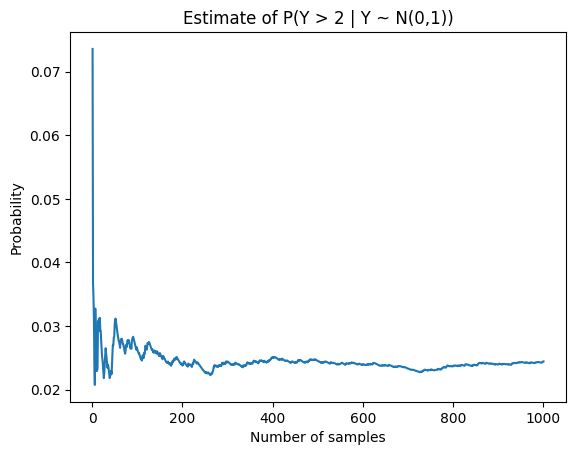

In [12]:
# Create a consistent random number generator using NumPy's `default_rng`
generator = np.random.default_rng(seed=42)

p_mean, p_var = (0.0, 1.0)
q_mean, q_var = (2.0, 1.0)
samples = generator.normal(loc=q_mean, scale=q_var, size=(T))
sample_probs_under_p = scipy.stats.norm(loc=p_mean, scale=p_var).pdf(samples)
sample_probs_under_q = scipy.stats.norm(loc=q_mean, scale=q_var).pdf(samples)
samples_greater_than_2 = (samples > 2) * 1
samples_weighted = samples_greater_than_2 * (sample_probs_under_p / sample_probs_under_q)
samples_weighted_cumsum = samples_weighted.cumsum()

f_IS = samples_weighted_cumsum / num_samples_t
# display(f_IS)

sb.lineplot(x=num_samples_t, y=f_IS)
plt.title('Estimate of P(Y > 2 | Y ~ N(0,1))')
plt.xlabel('Number of samples')
plt.ylabel('Probability')

display(f'f_MC(T) = {f_IS[-1]}')

When the number of samples is small, importance sampling is biased, hence we get an estimate which is pretty far off from the "true" probability. However, because samples are being drawn from around the decision boundary, the estimated probability quickly settles near the true probability.

### 1. (c) Compare and explain

Write a few sentences comparing Figures 1a and 1b: How and why do they differ? What is a broad lesson about Monte Carlo approximation that we can learn from this comparison?

Naive Monte Carlo converges more slowly than Importance Sampling Monte Carlo for this choice of surrogate distribution. This is because, with a good surrogate distribution like the one we use here, samples which are informative for our estimate are drawn more frequently than otherwise.

However, we also know Importance Sampling Monte Carlo is a biased estimator, hence we see that the converged estimate is consistently above the true probability. Contrast this with Naive Monte Carlo, where the estimate frequently undershoots the true probability but is (importantly) NOT biased.